Visualizing NBA Shots with `py-Goldsberry`
===

One of the coolest features of `py-Goldsberry` is access to raw data for NBA shots. 

Visualizing NBA shot charts as a method of analytics was proposed by Kirk Goldsberry at the 2012 MIT Sloan Sports Analytics Conference ([read paper](http://www.sloansportsconference.com/wp-content/uploads/2012/02/Goldsberry_Sloan_Submission.pdf)). 

Given the data `py-Goldsberry` provides access to and the methods proposed by it's namesake, it would be inappropriate to not include some additional functionality that eased the creation of shot charts for NBA data. Thanks to some great work by (Savvas), the `py-Goldsberry` user has the ability to easily acquire and visualize NBA shooting data in Python.

###Getting The Data

We start by getting the data that we want to visualize. We can do this by using the `player.shot_chart()` class on a player ID

In [12]:
import goldsberry
import pandas as pd
pd.set_option("display.max_columns", 50)
goldsberry.__version__

'0.6.0'

In [13]:
players_2014 = goldsberry.PlayerList(2014)
players_2014 = pd.DataFrame(players_2014)

We have a DataFrame of players and their ids that we can use to get information on a specific player. For the sake of simplicity, we are going to study the shooting pattern of James Harden. To get his ID, we can either scroll through the table or do a quick filter using Pandas.

In [14]:
harden_id = players_2014['PERSON_ID'].ix[players_2014['DISPLAY_LAST_COMMA_FIRST'].str.contains("Harden")]
harden_id

196    201935
Name: PERSON_ID, dtype: int64

Now that we have the unique **PERSON_ID** for James, we can collect information on his shots using another `py-Goldsberry` class, `player.shot_chart()`

In [24]:
harden_shots = goldsberry.player.shot_chart(harden_id, season=2014, clutchtime=8)
harden_shots = pd.DataFrame(harden_shots.chart())
harden_shots.head()

,ACTION_TYPE,EVENT_TYPE,GAME_EVENT_ID,GAME_ID,GRID_TYPE,LOC_X,LOC_Y,MINUTES_REMAINING,PERIOD,PLAYER_ID,PLAYER_NAME,SECONDS_REMAINING,SHOT_ATTEMPTED_FLAG,SHOT_DISTANCE,SHOT_MADE_FLAG,SHOT_TYPE,SHOT_ZONE_AREA,SHOT_ZONE_BASIC,SHOT_ZONE_RANGE,TEAM_ID,TEAM_NAME
0,Jump Shot,Missed Shot,18,0021400003,Shot Chart Detail,226,39,9,1,201935,James Harden,58,1,22,0,3PT Field Goal,Right Side(R),Right Corner 3,24+ ft.,1610612745,Houston Rockets
1,Layup Shot,Missed Shot,39,0021400003,Shot Chart Detail,-15,15,8,1,201935,James Harden,25,1,2,0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612745,Houston Rockets
2,Jump Shot,Made Shot,41,0021400003,Shot Chart Detail,-232,110,8,1,201935,James Harden,21,1,25,1,3PT Field Goal,Left Side Center(LC),Above the Break 3,24+ ft.,1610612745,Houston Rockets
3,Jump Shot,Missed Shot,95,0021400003,Shot Chart Detail,-146,135,4,1,201935,James Harden,32,1,19,0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612745,Houston Rockets
4,Driving Layup Shot,Made Shot,120,0021400003,Shot Chart Detail,-8,22,2,1,201935,James Harden,38,1,2,1,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612745,Houston Rockets


---

In [1]:
import numpy as np
from scipy.stats import binned_statistic_2d
import seaborn as sns
from bokeh.plotting import figure
from math import pi

In [2]:
%matplotlib inline

import urllib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
urllib.__version__

'1.17'

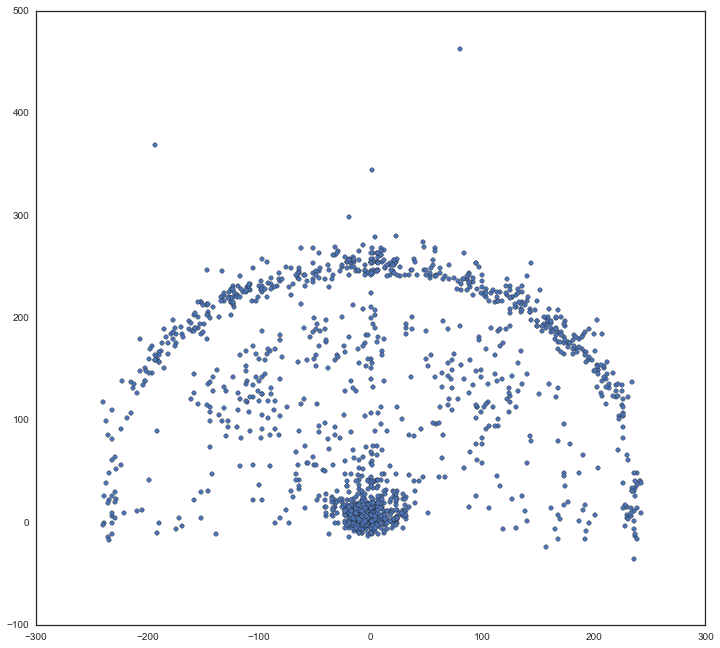

In [26]:
sns.set_style("white")
sns.set_color_codes()
plt.figure(figsize=(12,11))
plt.scatter(harden_shots.LOC_X, harden_shots.LOC_Y)
plt.show()

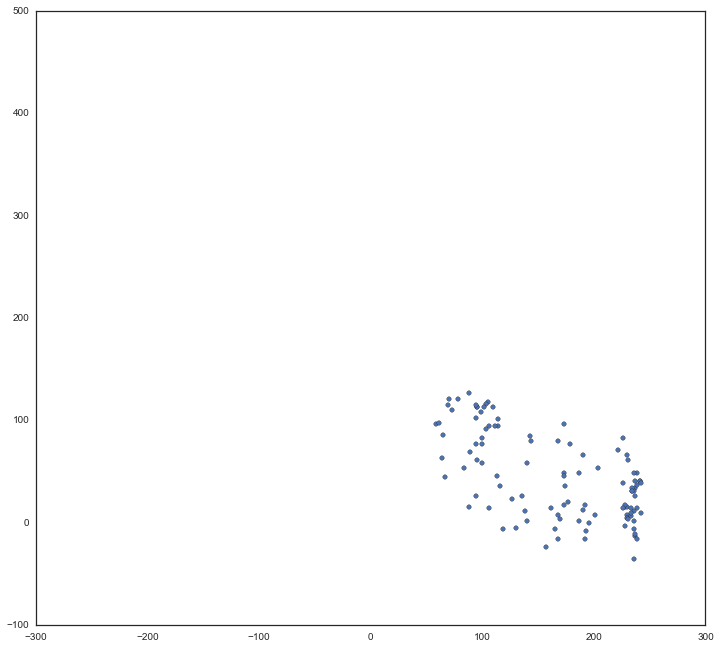

In [27]:
right = harden_shots[harden_shots.SHOT_ZONE_AREA == "Right Side(R)"]
plt.figure(figsize=(12,11))
plt.scatter(right.LOC_X, right.LOC_Y)
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

In [28]:
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

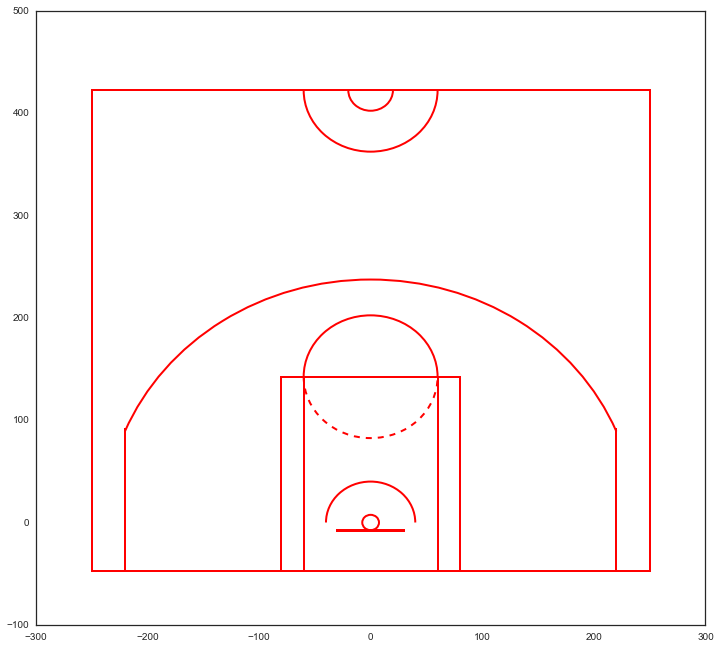

In [73]:
plt.figure(figsize=(12,11))
draw_court(outer_lines=True, color="red")
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

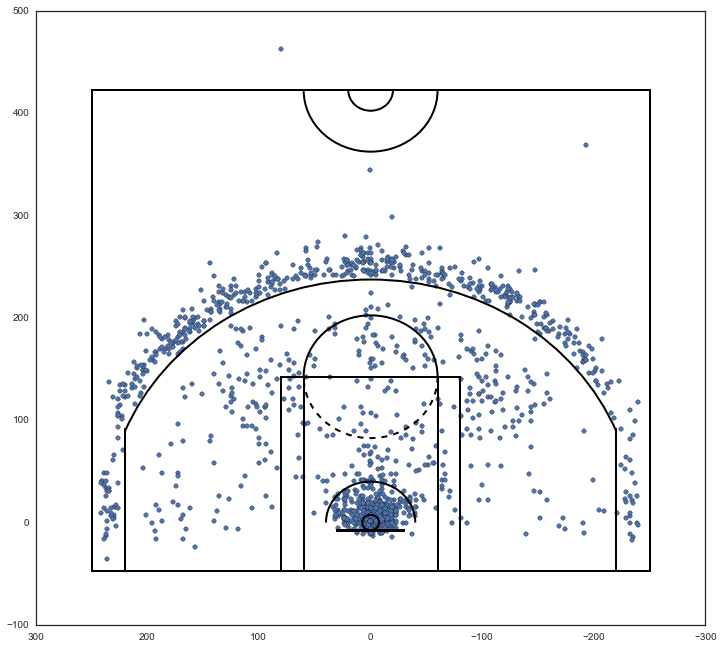

In [66]:
plt.figure(figsize=(12,11))
plt.scatter(harden_shots.LOC_X, harden_shots.LOC_Y)
draw_court(outer_lines=True)
# Descending values along the axis from left to right
plt.xlim(300,-300)
plt.show()

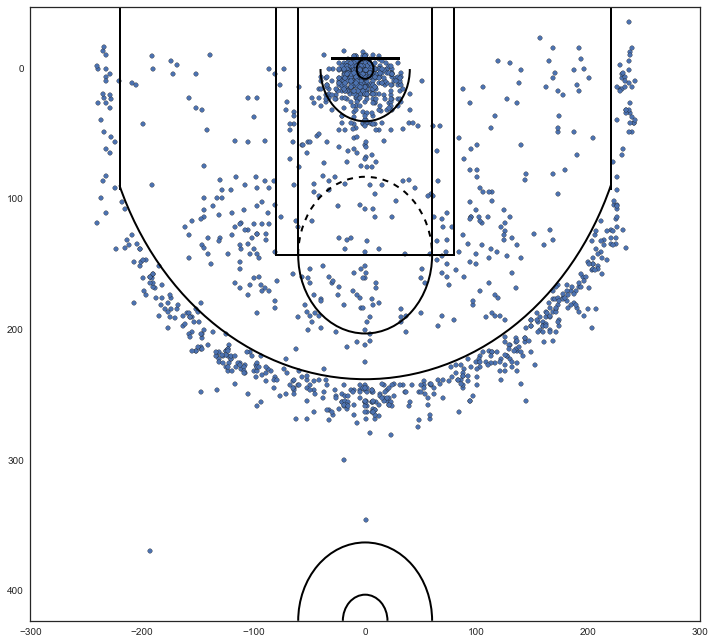

In [68]:
plt.figure(figsize=(12,11))
plt.scatter(harden_shots.LOC_X, harden_shots.LOC_Y)
draw_court()
# Adjust plot limits to just fit in half court
plt.xlim(-300,300)
# Descending values along th y axis from bottom to top
# in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)
# get rid of axis tick labels
# plt.tick_params(labelbottom=False, labelleft=False)
plt.show()

In [45]:
x = harden_id.tolist()[0]

In [61]:
def get_player_img(player_id):
    """Returns the image of the player from stats.nba.com

    Parameters
    ----------
    player_id: int
        The player ID used to find the image.
    """
    url = "http://stats.nba.com/media/players/230x185/"+str(player_id)+".png"
    img_file = str(player_id) + ".png"
    img = plt.imread(urllib.urlretrieve(url, img_file)[0])
    return plt.imshow(img)

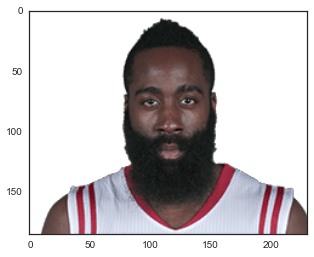

In [62]:
get_player_img(x)

In [5]:
def draw_court(ax=None, color='gray', lw=1, outer_lines=False):
    """
    Returns an axes with a basketball court drawn onto to it.

    This function draws a court based on the x and y-axis values that the NBA
    stats API provides for the shot chart data.  For example, the NBA stat API
    represents the center of the hoop at the (0,0) coordinate.  Twenty-two feet
    from the left of the center of the hoop in is represented by the (-220,0)
    coordinates.  So one foot equals +/-10 units on the x and y-axis.

    TODO: explain the parameters
    """
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the right side 3pt lines, it's 14ft long before it arcs
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    # Create the right side 3pt lines, it's 14ft long before it arcs
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

Shot_Chart function should take a dataset as an argument and return a shot chart
* Scatter should differentiate between ACTION_TYPE, EVENT_TYPE, SHOT_TYPE, SHOT_ZONE_AREA, SHOT_ZONE_BASIC, SHOT_ZONE_RANGE, TEAM_NAME, PLAYER_NAME 
* Scatter set dot size, color, alpha

In [ ]:
harden_shot_master = pd.merge(harden_shots, harden_shots_advanced, how='left', left_on=['GAME_ID', 'PERIOD', 'MINUTES_REMAINING', 'SECONDS_REMAINING'])

In [96]:
harden_shots_advanced.tail()

,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,DRIBBLES,FGM,FINAL_MARGIN,GAME_CLOCK,GAME_ID,LOCATION,MATCHUP,PERIOD,PTS,PTS_TYPE,SHOT_CLOCK,SHOT_DIST,SHOT_NUMBER,SHOT_RESULT,TOUCH_TIME,W
1438,"Hill, Jordan",201941,0.7,1,0,18,0:02,0021400003,A,"OCT 28, 2014 - HOU @ LAL",2,0,2,NaN,3.9,13,missed,1.8,W
1439,"Johnson, Wesley",202325,1.9,0,0,18,7:21,0021400003,A,"OCT 28, 2014 - HOU @ LAL",3,0,2,6.9,19.6,14,missed,0.4,W
1440,"Johnson, Wesley",202325,5.0,1,1,18,6:09,0021400003,A,"OCT 28, 2014 - HOU @ LAL",3,2,2,18.4,23.5,15,made,0.8,W
1441,"Davis, Ed",202334,3.6,6,1,18,2:37,0021400003,A,"OCT 28, 2014 - HOU @ LAL",3,2,2,16.3,5.8,16,made,6.1,W
1442,"Henry, Xavier",202333,4.1,5,0,18,0:34,0021400003,A,"OCT 28, 2014 - HOU @ LAL",3,0,3,10.1,24.9,17,missed,8.3,W


In [88]:
harden_shots.head()

,ACTION_TYPE,EVENT_TYPE,GAME_EVENT_ID,GAME_ID,GRID_TYPE,LOC_X,LOC_Y,MINUTES_REMAINING,PERIOD,PLAYER_ID,PLAYER_NAME,SECONDS_REMAINING,SHOT_ATTEMPTED_FLAG,SHOT_DISTANCE,SHOT_MADE_FLAG,SHOT_TYPE,SHOT_ZONE_AREA,SHOT_ZONE_BASIC,SHOT_ZONE_RANGE,TEAM_ID,TEAM_NAME
0,Jump Shot,Missed Shot,18,0021400003,Shot Chart Detail,226,39,9,1,201935,James Harden,58,1,22,0,3PT Field Goal,Right Side(R),Right Corner 3,24+ ft.,1610612745,Houston Rockets
1,Layup Shot,Missed Shot,39,0021400003,Shot Chart Detail,-15,15,8,1,201935,James Harden,25,1,2,0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612745,Houston Rockets
2,Jump Shot,Made Shot,41,0021400003,Shot Chart Detail,-232,110,8,1,201935,James Harden,21,1,25,1,3PT Field Goal,Left Side Center(LC),Above the Break 3,24+ ft.,1610612745,Houston Rockets
3,Jump Shot,Missed Shot,95,0021400003,Shot Chart Detail,-146,135,4,1,201935,James Harden,32,1,19,0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612745,Houston Rockets
4,Driving Layup Shot,Made Shot,120,0021400003,Shot Chart Detail,-8,22,2,1,201935,James Harden,38,1,2,1,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612745,Houston Rockets


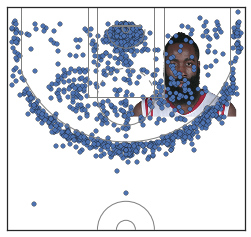

In [86]:
shot_chart(harden_shots, likeness=harden_id.tolist()[0])

In [84]:
def shot_chart(data, x="LOC_X", y="LOC_Y", title="", kind="scatter", color="b", cmap=None,
               likeness=False, xlim=(-250, 250), ylim=(422.5, -47.5),
               court_color="gray", outer_lines=False, court_lw=1,
               flip_court=False, kde_shade=True, hex_gridsize=None,
               ax=None, **kwargs):
    """
    data: dataset to be visualizaed
    x = "LOC_X": default column name in dataset with X Coordinates
    y = "LOC_Y": default column name in dataset with Y Coordinates
    title="":
    kind = "scatter": Type of visual, default is "scatter"; takes: "scatter", "kde", "hex"
    color = "b": default color
    cmap = None: default color map
    likeness = None: Logical indicator to determine inclusion of player photo. Takes player ID value
    xlim = (-250,250): default plot limits
    ylim = (422.5, -47.5),
    court_color = "gray":
    outer_lines=False:
    hex_gridsize=None:
    ax=None:
    **kwargs
    """

    if ax is None:
        ax = plt.gca()

    if cmap is None:
        cmap = sns.light_palette(color, as_cmap=True)

    if not flip_court:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    else:
        ax.set_xlim(xlim[::-1])
        ax.set_ylim(ylim[::-1])

    ax.tick_params(labelbottom="off", labelleft="off")
    ax.set_title(title, fontsize=18)

    draw_court(ax, color=court_color, lw=court_lw, outer_lines=outer_lines)

    if kind == "scatter":
        ax.scatter(data[x], data[y], c=color, **kwargs)

    elif kind == "kde":
        sns.kdeplot(data[x], data[y], shade=kde_shade, cmap=cmap,
                    ax=ax, **kwargs)
        ax.set_xlabel('')
        ax.set_ylabel('')

    elif kind == "hex":
        if hex_gridsize is None:
            # Get the number of bins for hexbin using Freedman-Diaconis rule
            # This is idea was taken from seaborn, which got the calculation
            # from http://stats.stackexchange.com/questions/798/
            from seaborn.distributions import _freedman_diaconis_bins
            x_bin = _freedman_diaconis_bins(data[x])
            y_bin = _freedman_diaconis_bins(data[y])
            hex_gridsize = int(np.mean([x_bin, y_bin]))

        ax.hexbin(data[x], data[y], gridsize=hex_gridsize, cmap=cmap, **kwargs)

    else:
        raise ValueError("kind must be 'scatter', 'kde', or 'hex'.")

    if likeness is not None:
        get_player_img(likeness)
        
    return ax

In [9]:
def heatmap_fgp(x, y, z, bins=20, title="", cmap=plt.cm.YlOrRd,
                xlim=(-250, 250), ylim=(422.5, -47.5),
                facecolor='lightgray', facecolor_alpha=0.4,
                court_color="black", outer_lines=False, court_lw=0.5,
                flip_court=False, ax=None, **kwargs):

    """
    Returns an AxesImage object that contains a heatmap of the FG%

    TODO: Explain parameters
    """

    # Bin the FGA (x, y) and Calculcate the mean number of times shot was
    # made (z) within each bin
    # mean is the calculated FG percentage for each bin
    mean, xedges, yedges, binnumber = binned_statistic_2d(x=x, y=y,
                                                          values=z,
                                                          statistic='mean',
                                                          bins=bins)

    if ax is None:
        ax = plt.gca()

    if not flip_court:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    else:
        ax.set_xlim(xlim[::-1])
        ax.set_ylim(ylim[::-1])

    ax.tick_params(labelbottom="off", labelleft="off")
    ax.set_title(title, fontsize=18)

    ax.patch.set_facecolor(facecolor)
    ax.patch.set_alpha(facecolor_alpha)

    draw_court(ax, color=court_color, lw=court_lw, outer_lines=outer_lines)

    heatmap = ax.imshow(mean.T, origin='lower', extent=[xedges[0], xedges[-1],
                        yedges[0], yedges[-1]], interpolation='nearest',
                        cmap=plt.cm.YlOrRd)

    return heatmap

In [10]:
# Bokeh Shot Chart
def bokeh_draw_court(figure, line_width=1, line_color='gray'):
    """Returns a figure with the basketball court lines drawn onto it"""

    # hoop
    figure.circle(x=0, y=0, radius=7.5, fill_alpha=0,
                  line_color=line_color, line_width=line_width)

    # backboard
    figure.line(x=range(-30,31), y=-7.5, line_color=line_color)

    # The paint
    # outerbox
    figure.rect(x=0, y=47.5, width=160, height=190,fill_alpha=0, 
                line_color=line_color, line_width=line_width)
    # innerbox
    # left inner box line
    figure.line(x=-60, y=np.arange(-47.5, 143.5), line_color=line_color,
                line_width=line_width)
    # right inner box line
    figure.line(x=60, y=np.arange(-47.5, 143.5), line_color=line_color,
                line_width=line_width)

    # Restricted Zone
    figure.arc(x=0, y=0, radius=40, start_angle=pi, end_angle=0,
               line_color=line_color, line_width=line_width)

    # top free throw arc
    figure.arc(x=0, y=142.5, radius=60, start_angle=pi, end_angle=0,
               line_color=line_color)

    # bottome free throw arc
    figure.arc(x=0, y=142.5, radius=60, start_angle=0, end_angle=pi,
               line_color=line_color, line_dash="dashed")

    # Three point line
    # corner three point lines
    figure.line(x=-220, y=np.arange(-47.5, 92.5), line_color=line_color,
                line_width=line_width)
    figure.line(x=220, y=np.arange(-47.5, 92.5), line_color=line_color,
                line_width=line_width)
    # # three point arc
    figure.arc(x=0, y=0, radius=237.5, start_angle=3.528, end_angle=-0.3863,
               line_color=line_color, line_width=line_width)

    # add center court
    # outer center arc
    figure.arc(x=0, y=422.5, radius=60, start_angle=0, end_angle=pi,
               line_color=line_color, line_width=line_width)
    # inner center arct
    figure.arc(x=0, y=422.5, radius=20, start_angle=0, end_angle=pi,
               line_color=line_color, line_width=line_width)


    # outer lines, consistting of half court lines and out of bounds
    # lines
    figure.rect(x=0, y=187.5, width=500, height=470, fill_alpha=0,
                line_color=line_color, line_width=line_width)
    
    return figure

In [11]:
def bokeh_shot_chart(source, x="LOC_X", y="LOC_Y", fill_color="#1f77b4",
                     fill_alpha=0.3, line_alpha=0.3, court_lw=1,
                     court_line_color='gray'):
    """
    Returns a figure with both FGA and basketball court lines drawn onto it.

    This function expects data to be a ColumnDataSource with the x and y values
    named "LOC_X" and "LOC_Y".  Otherwise specify x and y.
    """

    fig = figure(width=700, height=658, x_range=[-250, 250],
                 y_range=[422.5, -47.5], min_border=0,
                 x_axis_type=None, y_axis_type=None,
                 outline_line_color="black")

    fig.scatter(x, y, source=source, size=10, fill_alpha=0.3,
                line_alpha=0.3)

    bokeh_draw_court(fig, line_color='gray')

    return fig